In [1]:
from autograd import grad
import matplotlib.pyplot as plt
import autograd.numpy as np  # We need to use this numpy wrapper to make automatic differentiation work later
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [2]:
# Defining some activation functions
def ReLU(z):
    return np.where(z > 0, z, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    e_z = np.exp(z - np.max(z, axis=0))
    return e_z / np.sum(e_z, axis=1)[:, np.newaxis]

def cross_entropy(predict, target):
    return np.sum(-target * np.log(predict))

In [3]:
def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def sigmoid_der(z):
    sigm = sigmoid(z)
    return sigm * (1 - sigm)

def softmax_der(z):
    return 1


In [4]:
def crossentropy_der(predict, target): # cost function, not activation!!!
    return predict - target

def cost(input, layers, activation_funcs, target):
    predict = feed_forward_batch(input, layers, activation_funcs)
    return cross_entropy(predict, target)

In [5]:
def mse_der(predict, target):
    return (2 * (predict - target)) / target.size


def mse(predict, target):
    return np.mean((predict - target) ** 2)


'''def cost(input, layers,activation_funcs, target):
    predict = feed_forward_batch(input, layers, activation_funcs)
    return mse(predict, target)'''

'def cost(input, layers,activation_funcs, target):\n    predict = feed_forward_batch(input, layers, activation_funcs)\n    return mse(predict, target)'

In [6]:
def accuracy(predictions, targets):
    one_hot_predictions = np.zeros(predictions.shape)

    for i, prediction in enumerate(predictions):
        one_hot_predictions[i, np.argmax(prediction)] = 1
    return accuracy_score(one_hot_predictions, targets)

In [7]:
def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []
    i_size = network_input_size  
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        W = W.T
        b = np.random.randn(layer_output_size)
        layers.append((W, b))
        i_size = layer_output_size
    return layers


def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = a @ W + b
        a = activation_func(z)
    return a


def feed_forward_saver_batch(inputs, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)        
        z = a @ W + b
        a = activation_func(z)
        zs.append(z)
    return layer_inputs, zs, a

def backpropagation_batch(inputs, layers, activation_funcs, target, activation_ders, cost_der):
    layer_inputs, zs, predict = feed_forward_saver_batch(inputs, layers, activation_funcs)
    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict,target) # (predict - target)*2/target.shape[1] # (n, tf)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = dC_dz @ W.T # 

        dC_dz = dC_da * activation_der(z) # (n, tf)
        dC_dW = np.matmul(layer_input.T, dC_dz)/target.shape[0] # remember to divide by n
        dC_db = np.mean(dC_dz, axis = 0) # (n, tf)
        layer_grads[i] = (dC_dW, dC_db)
    print(layer_grads)

    return layer_grads 

In [8]:
def train_network(_inputs, _layers, activation_funcs, targets, activation_ders, learning_rate=0.001, epochs=30):
    predictions = []
    prediction = _inputs
    for i in range(epochs):
        layers_grad =  backpropagation_batch(_inputs, _layers, activation_funcs, targets, activation_ders, cost_der=crossentropy_der)
        #layers_grad = gradient_func(_inputs, _layers, activation_funcs, targets)   
        for (W, b), (W_g, b_g) in zip(_layers, layers_grad):
            W -= W_g * learning_rate
            b -= b_g * learning_rate
        prediction = feed_forward_batch(_inputs,_layers,activation_funcs)
        predictions.append(prediction)

        print(accuracy(prediction, targets))

    return predictions

##  Start

In [9]:
iris = datasets.load_iris()
inputs = iris.data

# we need to make each target a vector with a 1 for the correct flower and a 0 for the others.
targets = np.zeros((len(iris.data), 3))
for i, t in enumerate(iris.target):
    targets[i, t] = 1

n_iter = 100
lern_rate = 0.01
network_input_size = len(inputs[0])
layer_output_sizes = [8, 3]
activation_funcs = [sigmoid, softmax]
activation_ders = [sigmoid_der, softmax_der]

In [10]:
layers = create_layers_batch(network_input_size, layer_output_sizes)
predictions = feed_forward_batch(inputs, layers, activation_funcs)
print('accuracy of the initial prediction: ', accuracy(predictions, targets))

accuracy of the initial prediction:  0.28


In [11]:
gradient_func = grad(cost, 1); # Taking the gradient wrt. the second input to the cost function, i.e. the layers
layers_grad = gradient_func(inputs, layers, activation_funcs, targets)  # Don't change this

In [12]:
predictions_final = train_network(inputs, layers, activation_funcs, targets, activation_ders, learning_rate=0.01, epochs=n_iter)

accuracy_values = []
for pred in predictions_final:
    acc = accuracy(pred, targets)
    accuracy_values.append(acc)

[(array([[ 1.43225609e-01,  1.09117889e-01,  8.12623942e-05,
         1.94899560e-01, -6.28408095e-02,  6.96132325e-05,
        -1.33918410e-01, -1.98213323e-02],
       [ 1.69556704e-02,  1.19647675e-01,  5.42201941e-05,
         1.33357550e-01, -5.17564805e-02,  2.48271135e-05,
        -5.79822793e-02, -1.33773035e-02],
       [ 2.07986123e-01, -6.44506012e-02,  2.34828081e-05,
         5.67321568e-02,  1.25958804e-03,  2.98102256e-05,
        -1.27354060e-01, -5.57736949e-03],
       [ 7.85898253e-02, -3.85572942e-02,  3.55438669e-06,
         9.26447357e-03,  5.81621349e-03, -4.51571163e-06,
        -5.01225884e-02, -9.25708634e-04]]), array([ 1.52255392e-02,  2.98853333e-02,  1.69485592e-05,  3.89987006e-02,
       -1.43454978e-02,  1.48980541e-05, -1.83926724e-02, -4.03819981e-03])), (array([[ 6.04247399e-02, -2.42855678e-02, -3.61391721e-02],
       [-1.17196499e-02,  4.91652357e-03,  6.80312629e-03],
       [-1.13603958e-04,  5.37993331e-05,  5.98046246e-05],
       [-3.8669604

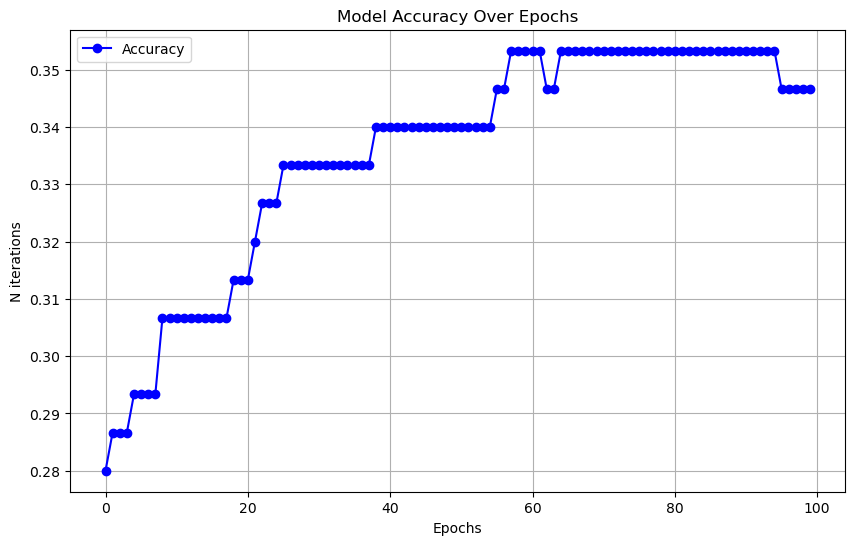

In [13]:
range_x = range(0, n_iter, 1)
plt.figure(figsize=(10, 6))
plt.plot(range_x, accuracy_values, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('N iterations')
plt.grid()
plt.legend()
plt.show()